<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/08_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to NLP Fundamental with TensorFlow

##Getting the dataset

The dataset we're gonna use is kaggle's Introduction to NLP dataset. (text sample of tweets cintaining labels as disaster and non-disaster)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
import zipfile
zip_dir = zipfile.ZipFile('nlp_getting_started.zip')
zip_dir.extractall()
zip_dir.close()

--2024-05-08 14:57:28--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-05-08 14:57:28 (129 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df['text'][87]

'RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone conf\x89Û_'

In [8]:
train_df.drop(columns=['keyword', 'location'], inplace=True)
test_df.drop(columns=['keyword', 'location'], inplace=True)

In [9]:
train_df.columns, test_df.columns

(Index(['id', 'text', 'target'], dtype='object'),
 Index(['id', 'text'], dtype='object'))

In [10]:
train_df['target'].unique()

array([1, 0])

In [11]:
## Shuffling the data
train_data = train_df.sample(frac=1, random_state=42) #fract: 1 is telling shuflle 100% of data
test_data = test_df

In [12]:
train_data.head()

,id,text,target
2644,3796,So you have a new weapon that can cause un-ima...,1
2227,3185,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,Aftershock back to school kick off was great. ...,0
6845,9810,in response to trauma Children of Addicts deve...,0


In [13]:
train_data.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [14]:
## Total Samples
len(train_df), len(test_df)

(7613, 3263)

In [15]:
## Visualizing random samples
import random
random_index = random.randint(0, len(train_data)-5)
for row in train_data[['text', 'target']][random_index: random_index+5].itertuples():
  _, text, target = row
  print("Target:",f'{target} (disaster)' if target>0 else f'{target} (not a disaster)')
  print(f"Text:\n {text}\n")
  print("-----\n")

Target: 0 (not a disaster)
Text:
 I had a meltdown in Demi's instagram comments http://t.co/mcc76xOwli

-----

Target: 0 (not a disaster)
Text:
 Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino

-----

Target: 0 (not a disaster)
Text:
 'Hey bitch blow me' uh no. Stick your dick in some water then an outlet so u get electrocuted..

-----

Target: 1 (disaster)
Text:
 Looks like a perfect storm-free evening coming up.  Check out the outdoor happenings featured at http://t.co/hUzrHgmkSY #EventsPalmBeach.

-----

Target: 0 (not a disaster)
Text:
 Rick and Morty - They Blew Up : http://t.co/UQKX5VbiuM

-----



##Split the data to training data and validation data

In [16]:
## The test data does not contain 'target' values so we cannot split the data to validation data
## So we split the data using train_data
from sklearn.model_selection import train_test_split
train_sentence, val_sentence, train_label, val_label = train_test_split(train_data['text'].to_numpy(),
                                                                        train_data['target'].to_numpy(),
                                                                        test_size=0.1,
                                                                        random_state=42)

In [17]:
len(train_sentence), len(val_sentence)

(6851, 762)

## Converting text into numbers

ways to do this:
* Tokenization
* Embedding

###Tokenization

In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [19]:
## Using default TextVectorization parameters
encoder = TextVectorization(max_tokens=None,
                       standardize='lower_and_strip_punctuation',
                       split='whitespace',
                       ngrams=None, ## Create groups of n-words
                       output_mode='int',
                       output_sequence_length=None,
                       pad_to_max_tokens=False)

In [20]:
train_sentence[1].split()

['Imagine', 'getting', 'flattened', 'by', 'Kurt', 'Zouma']

In [21]:
## Find the average number of tokens in the training data
round(sum([len(i.split()) for i in train_sentence])/len(train_sentence))

15

In [22]:
## Set up TextVectorizer variables
max_voc_length = 10000
max_length = 15
encoder = TextVectorization(max_tokens=max_voc_length,
                       output_mode='int',
                       output_sequence_length=max_length)

In [23]:
encoder.adapt(train_sentence)

In [24]:
sample_sentence = "There is a flood in the street!"
encoder([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,   2, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
## Choosing random sample from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentence)
print(random_sentence)
encoder([random_sentence]).numpy()

Soap and education are not as sudden as a massacre but they are more deadly in the long run. -- Mark Twain


array([[8334,    7, 2480,   22,   34,   26, 4509,   26,    3,  344,   30,
          64,   22,   51, 1690]])

In [26]:
## Get Unique words in the vocabulary
words_in_vocab = encoder.get_vocabulary() ## [UNK] is unknow
print(words_in_vocab[:5]) ## Starting 5 words
print(words_in_vocab[-5:]) ## Last 5 words
len(words_in_vocab) ## number of vocabulary

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


10000

###Creating an Embedding using an Embedding layer

using tf.keras.layers.Embedding()
it takes:
* `input_dim` - the size of our vocabulary.
* `ouput_dim` - the size of the embedding output vactor, for example, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` - length of the sequences being passed to the embedding layer.

In [27]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_voc_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length)
embedding

In [28]:
## Get a random sentence from trining set
random_sentence = random.choice(train_sentence)
print(f'Original Sentence: {random_sentence}\
      \n\n Embedded Version: ')

## Emded the random sentence (turn it into dense vectors of fixed size)
## We have to pass the inter values to the embedded layer
## So we do TextVectorizer first and pass the out put the embedding layer
sample_embed = embedding(encoder([random_sentence]))
sample_embed

Original Sentence: Hey @reddit - the concept of a 'quarantine' makes no sense if the people you've quarantined can just wander out &amp; about whenever they want      

 Embedded Version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02461292, -0.04756676, -0.03555448, ...,  0.0143205 ,
          0.031663  , -0.00264248],
        [-0.02774042, -0.0020944 , -0.00307208, ..., -0.03978112,
         -0.0432918 , -0.04563975],
        [ 0.0075372 , -0.00199107,  0.03745934, ...,  0.00669007,
          0.04844798,  0.03001681],
        ...,
        [-0.0171409 , -0.04775231, -0.04551117, ...,  0.03398294,
          0.04927239, -0.03384195],
        [ 0.02284913, -0.02679805, -0.04284856, ..., -0.03489203,
         -0.00966112, -0.02167652],
        [ 0.03922058,  0.03798211, -0.02456167, ...,  0.01255521,
          0.03997711, -0.04598236]]], dtype=float32)>

In [29]:
## Checkout singel token embedding
sample_embed[0][0], random_sentence.split()[0]
## the output is for 1 single word in sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02461292, -0.04756676, -0.03555448, -0.03376873,  0.00490786,
         0.01720209, -0.04187213, -0.04407315,  0.03872691,  0.03018333,
         0.03627637,  0.029243  ,  0.00157323, -0.01567773,  0.04251834,
         0.00496902,  0.03157668, -0.03043801,  0.02829869, -0.03188065,
        -0.01997988, -0.02442644, -0.02669275, -0.03797168,  0.00313019,
        -0.01313136,  0.0445242 , -0.0026705 ,  0.03293623,  0.00650197,
         0.04424119,  0.00564203, -0.00235917,  0.0306235 ,  0.02007767,
         0.02049427,  0.03010071,  0.02117994,  0.01683639, -0.00791143,
        -0.03905059,  0.02260072, -0.0209814 , -0.0207113 ,  0.01692582,
         0.04961145,  0.00047678,  0.04718268,  0.01296364,  0.03977824,
         0.01732553,  0.04477849, -0.00279893,  0.00436097,  0.04830334,
        -0.03626645,  0.04241775,  0.04493499, -0.00084033,  0.01206671,
         0.04410012,  0.04370185, -0.03804649,  0.0460435 , -0.03813449,
  

## Modelling a text dataset (Series of Experiment)

It's time to start modelling:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed Forword Neural Network (dense model)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D CNN
* Model 6: Tensorflow Hub Pretrained Feature Extractor
* Model 7: Same as Model 6 with 10% of the data

steps to follow
* Build a Model
* Fit the Model
* Evaluate the Model

### Model_0. Naive Bayes Model(baseline)

In [30]:
train_sentence[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), ## Converts text into numbers
    ('clf', MultinomialNB()) ## model
])

## Fit the Pipeline to train_data
model_0.fit(train_sentence, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
## Evaluate the Model
model_0_eval = model_0.score(val_sentence, val_label)
print(f"Got the accuracy score for evaluation data: {model_0_eval*100:.2f}%")

Got the accuracy score for evaluation data: 79.27%


In [33]:
## Predicting
model_0_preds = model_0.predict(test_data['text'])
model_0_preds[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [34]:
## Creatign function for evaluating the results
def calculate_results(y_true, y_pred):
  """
  Takes the actual target values (y_true) and predicted target values (y_pred) and
  makes evaluation using different evaluation methods like accuracy_score, precision,
  recall, f1-score, confusion_matrix.

  Args:

  Input:-
    y_true - True values
    y_pred - Predicted values
  Output:-
    Accuracy_Score, Precision, Recall, F1_Score, Confusion_Matrix
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  Accuracy_Score = accuracy_score(y_true, y_pred)
  Precision, Recall, F1_Score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_result = {'accuracy': Accuracy_Score, 'precision': Precision, 'recall': Recall, 'f1_score': F1_Score}

  return model_result

In [35]:
model_0_results = calculate_results(val_label, model_0.predict(val_sentence))
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model_1. Feed-Forword Neural Network

we can create in using
> We can use Sequential()
* encoder (TextVectorizer())
* Embedding()
* Feed-Forword NN (any model)
* Dense layer with activation
* Dense layer with ouput units

refer: https://www.tensorflow.org/text/tutorials/text_classification_rnn


In [36]:
train_sentence.shape, train_label.shape

((6851,), (6851,))

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

input = layers.Input(shape=(1, ), dtype=tf.string)

x = encoder(input)

x = embedding(x)

x = layers.GlobalAveragePooling1D()(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(input, output)


In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [39]:
## Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
history_1 = model_1.fit(x=train_sentence,
                        y=train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 6s 25ms/step - loss: 0.6122 - accuracy: 0.6979 - val_loss: 0.5399 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4416 - accuracy: 0.8178 - val_loss: 0.4719 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3470 - accuracy: 0.8615 - val_loss: 0.4656 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2847 - accuracy: 0.8897 - val_loss: 0.4643 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2380 - accuracy: 0.9114 - val_loss: 0.4784 - val_accuracy: 0.7848


<Axes: >

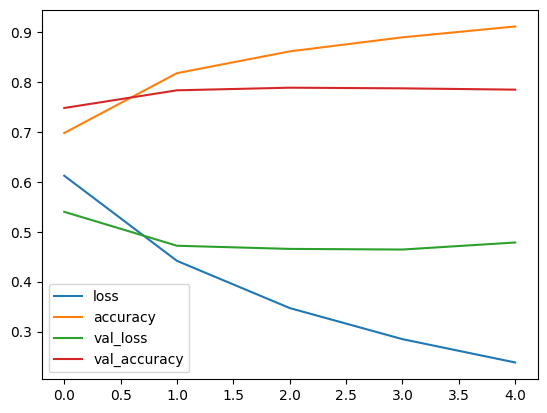

In [41]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

In [42]:
## check the results
model_1_eval = model_1.evaluate(val_sentence, val_label)
model_1_eval

24/24 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7848


[0.47840920090675354, 0.7847769260406494]

In [43]:
model_1_preds_probs = model_1.predict(val_sentence)
model_1_preds_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [44]:
model_1_preds_probs[0]

array([0.43711832], dtype=float32)

In [45]:
## Converting the probability to intergers (label format)
model_1_preds = [0 if value < 0.5 else 1 for value in model_1_preds_probs]
model_1_preds[:5]

[0, 1, 1, 0, 0]

In [46]:
model_1_results = calculate_results(val_label, model_1_preds)
model_1_results

{'accuracy': 0.7847769028871391,
 'precision': 0.7883861136419446,
 'recall': 0.7847769028871391,
 'f1_score': 0.7821779135639718}

### Visualizing Learned embedding

In [47]:
## Get the vocabulary from encoder (TextVectorizer)
words_in_vocab = encoder.get_vocabulary()
words_in_vocab[:10], len(words_in_vocab)

(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'], 10000)

In [48]:
## Model_1 summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [49]:
## Get the weight matrix of embedding layer
## these are numerical representation of each token in the training data , which has been learned for 5 epoch
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


> word enbedding: https://www.tensorflow.org/text/guide/word_embeddings

> tensorflow projector: https://projector.tensorflow.org/

In [50]:
# ## This code is taken by tensorflow word embedding documentation
## code is to get the embed weights to a csv files and visualize them with the help of prejuctor

# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

# ## This code will output 2 files

In [51]:
# ## Download files
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

### Recurrect Neural Network (RNN)

RNN's are useful for sequential data

The premise of recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

### Model_2: LSTM Model (RNN)

* LSTM: long short term memory (most popular).

> Input (text)  ->  Tokenize  ->  Embedding  ->  Layers (RNN/Dense)  ->  output (label probability)

In [52]:
## Creating the model

input = layers.Input(shape=(1, ), dtype='string')

x = encoder(input)

x = embedding(x)
# print(x.shape)

# x = layers.LSTM(units=64, return_sequences=True)(x) ## We need to set return_sequences=True
# print(x.shape)

x = layers.LSTM(units=64)(x) ## It takes 3 dimensions as an input
# print(x.shape)

x = layers.Dense(64, activation='relu')(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(input, output)

In [53]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                           

In [54]:
## Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [55]:
## fit the model
history_2 = model_2.fit(train_sentence,
                        train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 12s 44ms/step - loss: 0.2234 - accuracy: 0.9226 - val_loss: 0.5690 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 7s 30ms/step - loss: 0.1537 - accuracy: 0.9434 - val_loss: 0.5916 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 12s 56ms/step - loss: 0.1281 - accuracy: 0.9524 - val_loss: 0.6651 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 13s 62ms/step - loss: 0.1074 - accuracy: 0.9593 - val_loss: 0.8805 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0846 - accuracy: 0.9666 - val_loss: 1.0793 - val_accuracy: 0.7795


In [56]:
## Predicting the val_sentences
model_2_preds_probs = model_2.predict(val_sentence)
model_2_preds_probs[:6]

24/24 [==============================] - 1s 8ms/step


array([[3.0275172e-02],
       [9.7648805e-01],
       [9.9995774e-01],
       [2.0831892e-02],
       [1.0596527e-04],
       [9.9911726e-01]], dtype=float32)

In [57]:
## Converting the preds_probs to binary
model_2_preds = [0 if value < 0.5 else 1 for value in model_2_preds_probs]
model_2_preds[:6]

[0, 1, 1, 0, 0, 1]

In [58]:
7.4117346e-04, 8.9982188e-01

(0.00074117346, 0.89982188)

In [59]:
## evaluating the model_2
model_2_results = calculate_results(val_label, model_2_preds)
model_2_results

{'accuracy': 0.7795275590551181,
 'precision': 0.7797634583030512,
 'recall': 0.7795275590551181,
 'f1_score': 0.7784163768415738}

In [60]:
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model_3: GRU Model (RNN)

GRU: Gated Recurrent Unit (another popular RNN model)

In [61]:
inputs = layers.Input(shape=(1, ), dtype='string')

x = encoder(inputs)
x = embedding(x)

x = layers.GRU(64)(x) ## If we stack multiple RNN layers we hav to pass return_sequences=True

x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, output, name='Model_3')

In [62]:
model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                           

In [63]:
## compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [64]:
## Fit the model
history_3 = model_3.fit(train_sentence,
                        train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 20s 70ms/step - loss: 0.1547 - accuracy: 0.9362 - val_loss: 0.8210 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 12s 55ms/step - loss: 0.0825 - accuracy: 0.9692 - val_loss: 0.8561 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 13s 60ms/step - loss: 0.0682 - accuracy: 0.9730 - val_loss: 1.0755 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 12s 56ms/step - loss: 0.0538 - accuracy: 0.9761 - val_loss: 1.2535 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 12s 56ms/step - loss: 0.0554 - accuracy: 0.9762 - val_loss: 1.1587 - val_accuracy: 0.7690


In [65]:
model_3_preds_probs = model_3.predict(val_sentence)
model_3_preds_probs[:6]

24/24 [==============================] - 1s 7ms/step


array([[1.6119534e-02],
       [9.1078144e-01],
       [9.9999440e-01],
       [1.5556350e-01],
       [7.7172823e-05],
       [9.9988025e-01]], dtype=float32)

In [66]:
## Converting probaility to binary
model_3_preds = [0 if value < 0.5 else 1 for value in model_3_preds_probs]
model_3_preds[:6]

[0, 1, 1, 0, 0, 1]

In [67]:
## Calculating the results
model_3_results = calculate_results(val_label, model_3_preds)
model_3_results

{'accuracy': 0.7690288713910761,
 'precision': 0.7701356893081864,
 'recall': 0.7690288713910761,
 'f1_score': 0.7671875324347506}

In [68]:
## model_0 performence
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model_4: Bidirectional Neural Network

Normal RNN go from left to right, however the Bidirectional RNN goes from left to right as well as right to left.

> Look into the documentation:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional


In [69]:
input = layers.Input(shape=(1, ), dtype='string')

x = encoder(input)

x = embedding(x)

## The Bidirectional layer take input 'layer=' as other RNN layer (could any LSTM, GRU) and the that layer's retur_sequences must be true
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

x = layers.Bidirectional(layers.LSTM(64))(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(input, output, name='Model_4')

In [70]:
model_4.summary()

Model: "Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (

In [71]:
## Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [72]:
history_4 = model_4.fit(train_sentence,
                        train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 28s 84ms/step - loss: 0.1090 - accuracy: 0.9664 - val_loss: 0.8736 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 16s 75ms/step - loss: 0.0526 - accuracy: 0.9755 - val_loss: 1.1577 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 16s 74ms/step - loss: 0.0449 - accuracy: 0.9780 - val_loss: 1.4118 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 17s 77ms/step - loss: 0.0443 - accuracy: 0.9801 - val_loss: 1.4312 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 15s 69ms/step - loss: 0.0394 - accuracy: 0.9818 - val_loss: 1.5616 - val_accuracy: 0.7730


In [73]:
model_4_preds_probs = model_4.predict(val_sentence)
model_4_preds_probs[:6]

24/24 [==============================] - 1s 7ms/step


array([[3.7836170e-04],
       [9.7103536e-01],
       [9.9999404e-01],
       [1.2258885e-01],
       [1.3283302e-05],
       [9.9956721e-01]], dtype=float32)

In [74]:
## Converting the preds_probs
model_4_preds = [0 if value < 0.5 else 1 for value in model_4_preds_probs]
model_4_preds[:6]

[0, 1, 1, 0, 0, 1]

In [75]:
## Calculating the results
model_4_results = calculate_results(val_label, model_4_preds)
model_4_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7740517401498704,
 'recall': 0.7729658792650919,
 'f1_score': 0.7712160418848196}

In [76]:
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

###Model_5: 1Dimensional Convolutional Neural Network

> CNN Explainer: https://damien0x0023.github.io/rnnExplainer/

In [77]:
input = layers.Input(shape=(1, ), dtype='string')

x = encoder(input)

x = embedding(x)

x = layers.Conv1D(filters=32,
                  kernel_size=5,
                  activation='relu',
                  padding='same')(x)

x = layers.GlobalMaxPool1D()(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(input, output, name='Model_5')

In [78]:
model_5.summary()

Model: "Model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 15, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_6 (Dense)             (None, 1)                 33  

In [79]:
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [80]:
history_5 = model_5.fit(train_sentence,
                        train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.1246 - accuracy: 0.9675 - val_loss: 0.8379 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0693 - accuracy: 0.9762 - val_loss: 0.9893 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0574 - accuracy: 0.9781 - val_loss: 1.1026 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0519 - accuracy: 0.9790 - val_loss: 1.1211 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0477 - accuracy: 0.9791 - val_loss: 1.1591 - val_accuracy: 0.7664


In [81]:
model_5_preds_probs = model_5.predict(val_sentence)
model_5_preds_probs[:6]

24/24 [==============================] - 0s 3ms/step


array([[3.3938897e-01],
       [9.1641945e-01],
       [9.9995053e-01],
       [1.1694055e-01],
       [4.1045766e-07],
       [9.9729401e-01]], dtype=float32)

In [82]:
## Conveting to binary
model_5_preds = [0 if value < 0.5 else 1 for value in model_5_preds_probs]
model_5_preds[:6]

[0, 1, 1, 0, 0, 1]

In [83]:
## Calculating the result
model_5_results = calculate_results(val_label, model_5_preds)
model_5_results

{'accuracy': 0.7664041994750657,
 'precision': 0.7660521968917111,
 'recall': 0.7664041994750657,
 'f1_score': 0.7660953758696484}

In [84]:
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

###Model_6: TensroFlow-Hub pretrined Sentence encoder

In [85]:
sample_sentence

'There is a flood in the street!'

In [86]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the pre-trained USE model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# Define your sentences
sentences = [
    "This is the first sentence.",
    "This is another sentence to be encoded."
]

# Preprocess sentences (optional, might involve tokenization or text cleaning)
# ... (your preprocessing steps here)

# Encode sentences into embeddings
sentence_embeddings = embed(sentences)

# Access the embeddings (each a high-dimensional vector)
print(sentence_embeddings.numpy())

[[ 0.07880609  0.02494939 -0.00452747 ... -0.03346924  0.01937545
   0.08001192]
 [ 0.04926969  0.03004613 -0.01528579 ...  0.01828536  0.04724827
   0.03185968]]


In [87]:
sentence_embeddings.shape ## No matter what the input shape the output shape always will be [512]

TensorShape([2, 512])

In [88]:
## Create a Keras layer using the USE Pretrained layer from tensorflow hub
sentence_encode_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],
                                       dtype='string',
                                       trainable=False,
                                       name='USE')

In [89]:
## Creating model using Sequential API
model_6 = tf.keras.models.Sequential([
    sentence_encode_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
])

model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [90]:
## Fit the model
history_6 = model_6.fit(train_sentence,
                        train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 7s 22ms/step - loss: 0.5077 - accuracy: 0.7811 - val_loss: 0.4486 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.4168 - accuracy: 0.8129 - val_loss: 0.4444 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.4011 - accuracy: 0.8244 - val_loss: 0.4367 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3944 - accuracy: 0.8254 - val_loss: 0.4313 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3879 - accuracy: 0.8269 - val_loss: 0.4317 - val_accuracy: 0.8136


In [91]:
## Predicting
model_6_preds_probs = model_6.predict(val_sentence)
print(model_6_preds_probs[:6])
## Converting
model_6_preds = [0 if value < 0.5 else 1 for value in model_6_preds_probs]
model_6_preds[:6]

24/24 [==============================] - 1s 19ms/step
[[0.13525441]
 [0.7135776 ]
 [0.985544  ]
 [0.1964863 ]
 [0.7594068 ]
 [0.69179124]]


[0, 1, 1, 0, 1, 1]

In [92]:
## Calculating the result
model_6_results = calculate_results(val_label, model_6_preds)
model_6_results

{'accuracy': 0.8136482939632546,
 'precision': 0.8170954157228842,
 'recall': 0.8136482939632546,
 'f1_score': 0.8117426826050925}

In [93]:
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model_7: TF Hub pretrained USE with 10% training data

In [94]:
train_sentence, train_label

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        ...,
        'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
        "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
        "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
       dtype=object),
 array([0, 0, 1, ..., 1, 1, 0]))

In [95]:
## dividing the data by 10% in train_data
concatenated_df = pd.DataFrame({'text': train_sentence, 'target':train_label})
# concatenated_df.head()

train_10_percent = concatenated_df.sample(frac=0.1, random_state=42)
train_10_percent.head(), len(train_10_percent), len(concatenated_df)

(                                                   text  target
 1022  Families to sue over Legionnaires: More than 4...       1
 5740  @Jones94Kyle now I've said all this he's dead ...       0
 3153  @argentings WE COULD HAVE HAD IT AAAAAAALLLL I...       1
 3276  Map: Typhoon Soudelor's predicted path as it a...       1
 4874  So when r u getting married'@Foxy__Siren: Oh f...       0,
 685,
 6851)

In [96]:
train_sentence_10_percent = train_10_percent['text']
train_label_10_percent = train_10_percent['target']

In [97]:
model_7 = tf.keras.models.clone_model(model_6) ## It won't copy any weights, just the layers

model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [98]:
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [99]:
## Fitting the model
history_7 = model_7.fit(train_sentence_10_percent,
                        train_label_10_percent,
                        epochs=5,
                        validation_data=(val_sentence, val_label)) ## The validation remains same (becuase we are only training on 10 percent and evaluating the result)

Epoch 1/5
22/22 [==============================] - 5s 52ms/step - loss: 0.6631 - accuracy: 0.7139 - val_loss: 0.6451 - val_accuracy: 0.6969
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5915 - accuracy: 0.8161 - val_loss: 0.5948 - val_accuracy: 0.7336
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5182 - accuracy: 0.8307 - val_loss: 0.5423 - val_accuracy: 0.7572
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4569 - accuracy: 0.8380 - val_loss: 0.5130 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4143 - accuracy: 0.8423 - val_loss: 0.4963 - val_accuracy: 0.7703


In [100]:
model_7_preds_probs = model_7.predict(val_sentence)
print(model_7_preds_probs[:6])
model_7_preds = [0 if value < 0.5 else 1 for value in model_7_preds_probs]
model_7_preds[:6]

24/24 [==============================] - 1s 10ms/step
[[0.23798649]
 [0.77633137]
 [0.8751901 ]
 [0.3083503 ]
 [0.52195406]
 [0.79771584]]


[0, 1, 1, 0, 1, 1]

In [101]:
## Calculating the results
model_7_results = calculate_results(val_label, model_7_preds)
model_7_results

{'accuracy': 0.7703412073490814,
 'precision': 0.776479876261699,
 'recall': 0.7703412073490814,
 'f1_score': 0.7663654279032698}

In [102]:
model_6_results

{'accuracy': 0.8136482939632546,
 'precision': 0.8170954157228842,
 'recall': 0.8136482939632546,
 'f1_score': 0.8117426826050925}

In [103]:
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

The Model_6 outperformed well, but of course we could have added more layers and added more units (neurons) to our models but our goal was to use the base models.

## Comparing all Models performance

* Model 0: Naive Bayes (baseline)

* Model 1: Feed Forword Neural Network (dense model)

* Model 2: LSTM Model (RNN)

* Model 3: GRU Model (RNN)

* Model 4: Bidirectional LSTM (RNN)

* Model 5: 1D CNN

* Model 6: Tensorflow Hub Pretrained Feature Extractor

* Model 7: Same as Model 6 with 10% of the data

In [104]:
## We are ignoring the model_7, because it was only trained on 10% of the data

compare_dataframe = pd.DataFrame([model_0_results, model_1_results, model_2_results, model_3_results, model_4_results, model_5_results, model_6_results])
compare_dataframe.index = ['0_baseline', "1_simple_dense", '2_lstm', '3_gru', '4_bidirectional', '5_conv1d', '6_USE']

compare_dataframe

,accuracy,precision,recall,f1_score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.784777,0.788386,0.784777,0.782178
2_lstm,0.779528,0.779763,0.779528,0.778416
3_gru,0.769029,0.770136,0.769029,0.767188
4_bidirectional,0.772966,0.774052,0.772966,0.771216
5_conv1d,0.766404,0.766052,0.766404,0.766095
6_USE,0.813648,0.817095,0.813648,0.811743


In [105]:
## Sorting the df in descending order by 'accuracy', so that we can find the best performing model

compare_dataframe.sort_values(by='accuracy', ascending=False)

,accuracy,precision,recall,f1_score
6_USE,0.813648,0.817095,0.813648,0.811743
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.784777,0.788386,0.784777,0.782178
2_lstm,0.779528,0.779763,0.779528,0.778416
4_bidirectional,0.772966,0.774052,0.772966,0.771216
3_gru,0.769029,0.770136,0.769029,0.767188
5_conv1d,0.766404,0.766052,0.766404,0.766095


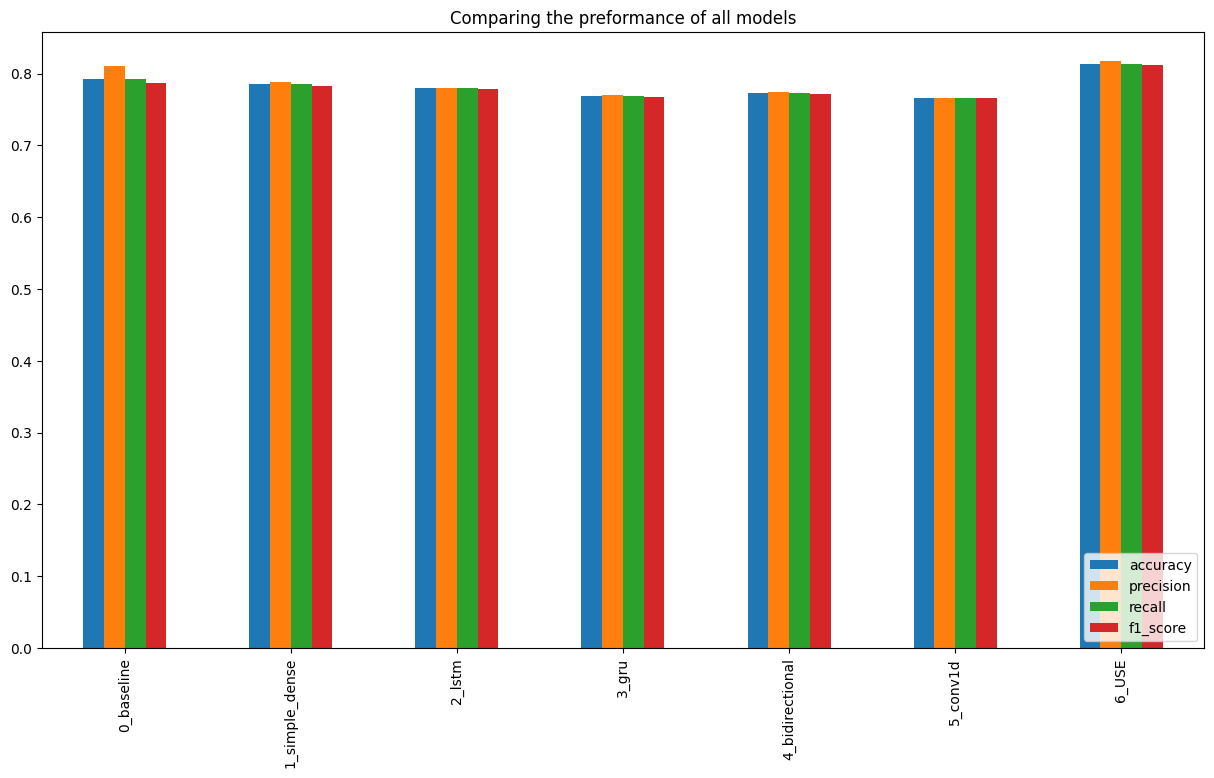

In [106]:
import matplotlib.pyplot as plt
compare_dataframe.plot(kind='bar', figsize=(15, 8))
plt.title('Comparing the preformance of all models')
plt.legend(loc='lower right')

<Axes: >

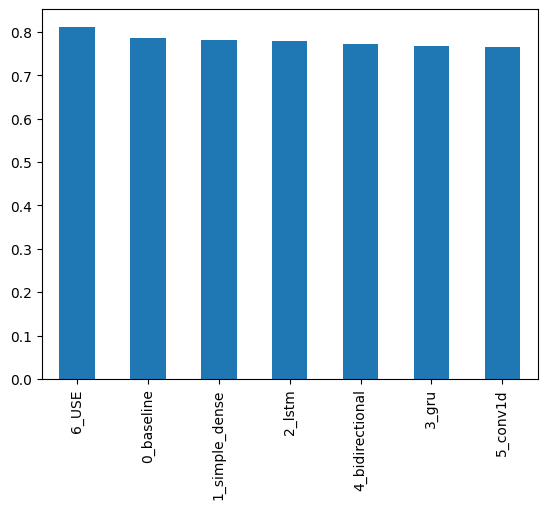

In [107]:
compare_dataframe.sort_values('f1_score', ascending=False)['f1_score'].plot(kind='bar')

## Saving and Loading a trained model

There are two ways to save models in TensorFlow
* The HDF5 format
* The `SaveModel` format

In [108]:
## Save the model_6 TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
## Load model with Custom Hub layer (required for HDF5 format)
loaded_model = tf.keras.models.load_model('model_6.h5',
                                          custom_objects={'KerasLayer': hub.KerasLayer})

In [116]:
## How our loaded model performs
loaded_model.evaluate(val_sentence, val_label)

24/24 [==============================] - 1s 11ms/step - loss: 0.4317 - accuracy: 0.8136


[0.4317000210285187, 0.8136482834815979]

In [113]:
## Save using SaveModel
model_6.save('model_6_save_format') ## This will create folder

In [117]:
## Load in the model
loaded_model_6_save_format = tf.keras.models.load_model('model_6_save_format')

In [118]:
loaded_model_6_save_format.evaluate(val_sentence, val_label)

24/24 [==============================] - 1s 11ms/step - loss: 0.4317 - accuracy: 0.8136


[0.4317000210285187, 0.8136482834815979]

##Predicting on the text data

In [138]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [140]:
test_data_preds_probs = model_6.predict(test_data['text'].tolist())
test_data_preds_probs[:6]

102/102 [==============================] - 4s 32ms/step


array([[0.51882964],
       [0.8604174 ],
       [0.8495907 ],
       [0.92814475],
       [0.95616996],
       [0.522428  ]], dtype=float32)

In [141]:
## Converting to binary
test_data_preds = [0 if value < 0.5 else 1 for value in test_data_preds_probs]

In [142]:
## Creating the dataframe of predited and test_data
test_preds_df = pd.DataFrame({'text': test_data['text'], 'label': test_data_preds})
test_preds_df.tail(6)

,text,label
3257,The death toll in a #IS-suicide car bombing on...,1
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,Storm in RI worse than last hurricane. My city...,1
3260,Green Line derailment in Chicago http://t.co/U...,1
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,1
3262,#CityofCalgary has activated its Municipal Eme...,1


In [143]:
test_preds_df[test_preds_df['label'] == 0]

,text,label
6,They'd probably still show more life than Arse...,0
7,Hey! How are you?,0
8,What a nice hat?,0
9,Fuck off!,0
10,No I don't like cold!,0
...,...,...
3248,Smackdown tyme this should put me in a good mo...,0
3249,@thrillhho jsyk I haven't stopped thinking abt...,0
3250,@stighefootball Begovic has been garbage. He g...,0
3251,Wrecked today got my hattrick ????,0


In [146]:
len(test_preds_df)

3263

In [144]:
len(test_preds_df[test_preds_df['label'] == 0]) ## len of 'not a disaster' in test_data

2089

In [145]:
len(test_preds_df[test_preds_df['label'] == 1]) ## len of 'disaster' in test_data

1174

## The Speed/Score tradeoff

In [150]:
## Let's create function to measure the time of prediction
import time
def pred_timer(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time / len(samples)

  return total_time, time_per_pred

In [152]:
## Calculate TF Hub Sentence Encoder time per pred
total_pred_time, time_per_pred = pred_timer(model_6, test_data['text'].tolist())
print("Total time taken to run:", total_pred_time)
print("time per prediction:", time_per_pred)

102/102 [==============================] - 1s 10ms/step
Total time taken to run: 1.3707361569995555
time per prediction: 0.0004200846328530664


In [153]:
## Calculating the baseline model (model_0) time takes to run
model_0_total_pred_time, model_0_time_per_pred = pred_timer(model_0, test_data['text'].tolist())
print("Total time taken to run:", model_0_total_pred_time)
print("time per prediction:", model_0_time_per_pred)

Total time taken to run: 0.07289027299975714
time per prediction: 2.2338422617148988e-05
